<a href="https://colab.research.google.com/github/cweidig/measuring_bias/blob/main/measure_bias_postprocess_3eq_odds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read the file mortgage_data_project.pkl from Google drive with pandas' read_pickle()
import pandas as pd
import seaborn as sns
import numpy as np

# Load the datset into a pandas dataframe
from joblib import load

df = load("/content/drive/My Drive/mortgage_data_preprocessed.pkl.gz")

In [ ]:
df.head()

,loan_amount_000s,applicant_income_000s,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,applicant_ethnicity_name_Hispanic or Latino,applicant_ethnicity_name_Not Hispanic or Latino,...,property_type_name_Manufactured housing,property_type_name_One-to-four family dwelling (other than manufactured housing),loan_purpose_name_Home improvement,loan_purpose_name_Home purchase,loan_purpose_name_Refinancing,loan_type_name_Conventional,loan_type_name_FHA-insured,loan_type_name_FSA/RHS-guaranteed,loan_type_name_VA-guaranteed,action_taken_name
0,102,151.0,5972.0,1.890000,66600.0,106.129997,1973.0,2194.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
1,114,30.0,4188.0,4.660000,49500.0,106.169998,1331.0,3113.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
2,105,112.0,9565.0,42.529999,61200.0,100.330002,2504.0,3149.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
3,270,182.0,5928.0,9.990000,67400.0,170.520004,1755.0,2102.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,False
4,62,36.0,4021.0,3.560000,54200.0,139.789993,1296.0,1487.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,False


In [ ]:
# install AIF360
!pip install aif360
!pip install fairlearn
!pip install 'aif360[inFairness]'

In [10]:
# Set up the fairness metrics to be computed using AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Create an object of type CalibratedEqOddsPostprocessing and store it in a variable called epp.
dataset = BinaryLabelDataset(df=df, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

from aif360.algorithms.postprocessing import EqOddsPostprocessing
privileged_group = [{'applicant_sex_name_Female': 0}]
unprivileged_group = [{'applicant_sex_name_Female': 1}]
epp = EqOddsPostprocessing(unprivileged_groups=unprivileged_group, privileged_groups=privileged_group, seed=42)

#dataset_transformed = epp.fit_transform(dataset)

In [ ]:
# Copy across your logistic regression routine

# Split the input and output variables using the cross-validator skf
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Consider the target variable (y) the action_taken_name. The input variables set (X) should contain all the remaining variables
# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

# setup the performance metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score,
                "Precision": metrics.precision_score,
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score,
                "F1-Score": metrics.f1_score,
                }

k, i = True, 1

for (train, test) in skf.split(X, y):
    # fit model
    lr = log_reg.fit(X.iloc[train], y.iloc[train].values.ravel())

    # get predictions in the test set
    X_test = X.iloc[test].copy()
    y_test = y.iloc[test].copy()
    ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
    ypred_class = lr.predict(X.iloc[test])

    # Split the test set into two: assign 60% to compute the postprocessing mix rates, and 40% as a postprocessing test set
    test_pct = 0.4
    n = int(len(y_test))
    n_2 = int(n* (1-test_pct)) # this is just a complicated way to do n * 0.6
    # NOTE randomizing indicies to get mix for both postprocess fit and predict groups
    indices = np.random.permutation(n)
    pp_indices = indices[:n_2]
    test_indices = indices[n_2:]

    # fit epp on the first 60% of indices in the test set
    # for both postprocess fit and predict compare actual label to predicted label
    pp_dataset = X_test.iloc[pp_indices].copy()
    pp_dataset[df.columns[-1]] = np.expand_dims(y_test.iloc[pp_indices], axis=1)
    pp_dataset_BLD = BinaryLabelDataset(df=pp_dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

    pp_pred = X_test.iloc[pp_indices].copy()
    pp_pred[df.columns[-1]] = np.expand_dims(ypred_class[pp_indices], axis=1)
    pp_pred_BLD = BinaryLabelDataset(df=pp_pred, label_names=[df.columns[-1]], protected_attribute_names=['applicant_sex_name_Female'])

    epp = epp.fit(pp_dataset_BLD, pp_pred_BLD)

    # Use epp to post-process predictions on the other 40% of the test set
    actuals_test = X_test.iloc[test_indices].copy()
    actuals_test[df.columns[-1]] = np.expand_dims(y_test.iloc[test_indices], axis=1)
    actuals_test_BLD = BinaryLabelDataset(df=actuals_test, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
    pred_test = X_test.iloc[test_indices].copy()
    pred_test[df.columns[-1]] = np.expand_dims(ypred_class[test_indices], axis=1)
    pred_test_BLD = BinaryLabelDataset(df=pred_test, label_names=[df.columns[-1]], protected_attribute_names=['applicant_sex_name_Female'])

    transf_pred_test_BLD = epp.predict(pred_test_BLD)

    # compute performance metrics
    metrics = []
    metric_CM = ClassificationMetric(actuals_test_BLD, transf_pred_test_BLD, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]

    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', metric_CM.statistical_parity_difference()]]
    metrics += [['Disparate Impact', metric_CM.disparate_impact()]]
    metrics += [['Equal Opportunity Difference', metric_CM.equal_opportunity_difference()]]
    metrics += [['Average Odds Difference', metric_CM.average_odds_difference()]]
    metrics += [['Accuracy Male', metric_CM.accuracy(privileged=True)]]
    metrics += [['Accuracy Female', metric_CM.accuracy(privileged=False)]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

In [ ]:
# Display metrics
metrics_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table

In [13]:
# Construct a DataFrame with allowable thresholds for plotting

fairness_df = pd.DataFrame(columns=["Metric", "Value", "Min", "Max"])
fairness_df.loc[0] = ['Disparate Impact'] + list((metrics_table[('mean', 'Value')]['Disparate Impact'], 0.8, 1.2))
fairness_df.loc[1] = ['Statistical Parity Difference'] + list((metrics_table[('mean', 'Value')]['Statistical Parity Difference'], -0.1, 0.1))
fairness_df.loc[2] = ['Average Odds Difference'] + list((metrics_table[('mean', 'Value')]['Average Odds Difference'], -0.1, 0.1))
fairness_df.loc[3] = ['Equal Opportunity Difference'] + list((metrics_table[('mean', 'Value')]['Equal Opportunity Difference'], -0.1, 0.1))

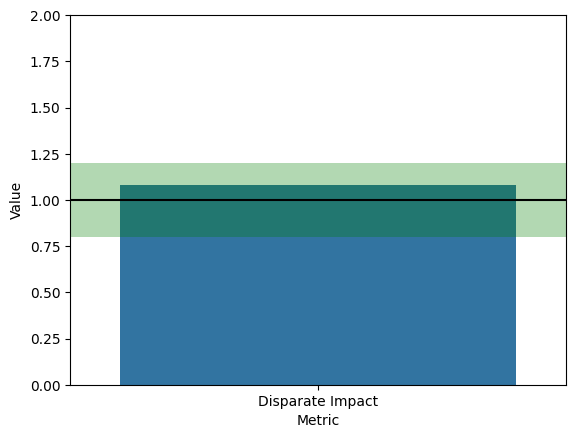

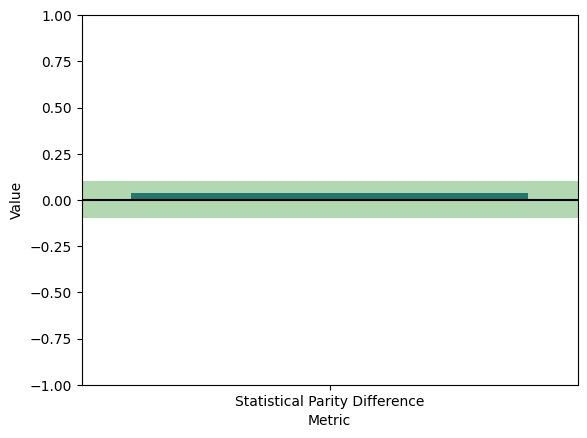

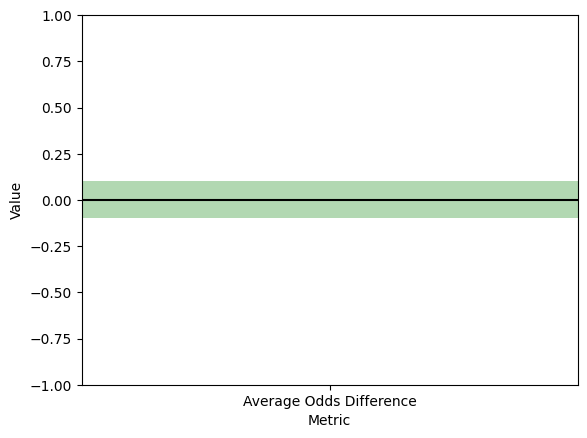

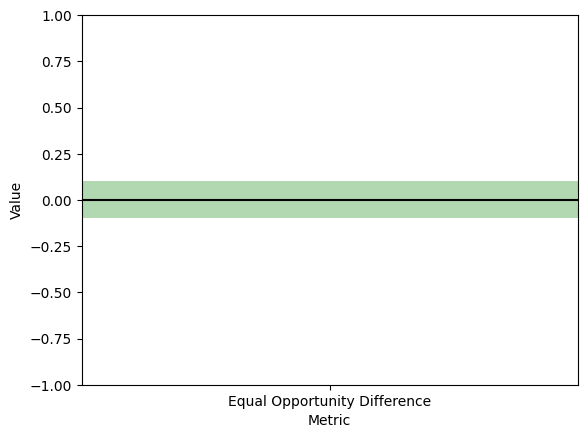

In [14]:
# Chart the metrics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

def plot_metrics(df_fair):
  def plot_metric(metric, ylim):
    fig, ax = plt.subplots()
    ax = sns.barplot(data=metric, x="Metric", y="Value")
    plt.axhline(np.mean(metric[["Min", "Max"]].values), color='black')
    plt.ylim(*ylim)
    range_height = metric[["Max"]].values[0][0] - metric[["Min"]].values[0][0]
    ax.add_patch(patches.Rectangle((-1, metric[["Min"]].values[0][0]), 2 , range_height, facecolor="green", alpha=0.3))

  plot_metric(df_fair.iloc[[0]], (0, 2))
  plot_metric(df_fair.iloc[[1]], (-1, 1))
  plot_metric(df_fair.iloc[[2]], (-1, 1))
  plot_metric(df_fair.iloc[[3]], (-1, 1))

plot_metrics(fairness_df)
